In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [2]:
import warnings
import os
import time
from glob import glob
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import xml
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import IPython.display as display

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import zipfile
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")

In [4]:
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")

In [5]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt
from PIL import Image 


### Load and preprocess images

In [6]:
SEED = 4250
np.random.seed(SEED)
random_dim = 128


# filepaths for image loading code
ROOT = '/kaggle/working/'
# list of all image file names in all-dogs
IMAGES = os.listdir(ROOT + 'all-dogs')
# list of all the annotation directories, each directory is a dog breed
BREEDS = os.listdir(ROOT + 'Annotation/') 

# variables that determine how tensorflow will create batches after data load
BUFFER_SIZE = 20000
BATCH_SIZE = 32

# weight initializers for the generator network
WEIGHT_INIT = RandomNormal(mean=0.0, stddev=0.05)

# generate/classify 64x64 images
IMG_SIZE = 64

# for training
EPOCHS = 100
NOISE_SIZE = 128
NB_EXAMPLES_TO_GENERATE = 16

# for animated GIF
# seed = tf.random.normal([NB_EXAMPLES_TO_GENERATE, NOISE_SIZE])


In [7]:
# Code slightly modified from user: cdeotte | https://www.kaggle.com/cdeotte/supervised-generative-dog-net

imgs = []
names = []

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# iterate through each directory in annotation
for breed in BREEDS:
    # iterate through each file in the directory
    for dog in os.listdir(ROOT+'Annotation/'+breed):
        try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg')
        except: continue
        # Element Tree library allows for parsing xml and getting specific tag values
        tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
        # take a look at the print out of an xml previously to get what is going on
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            imgs.append(np.asarray(img2))
            names.append(breed)

imgs = np.array(imgs)
names[:] = map(str.lower, names)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [8]:
print("imgs.shape: {}".format(imgs.shape))

imgs.shape: (22125, 64, 64, 3)


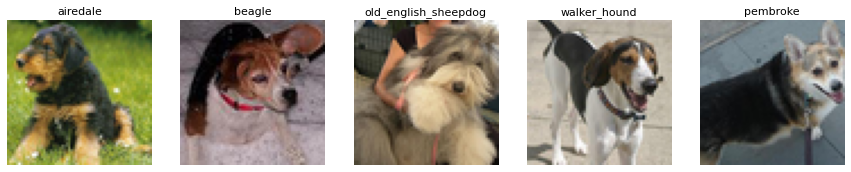

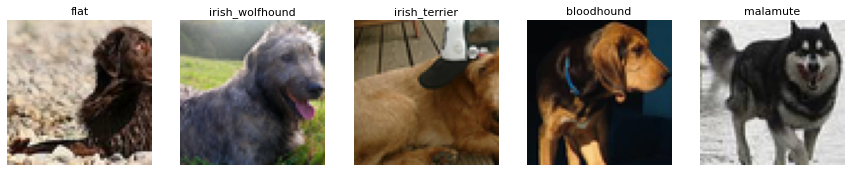

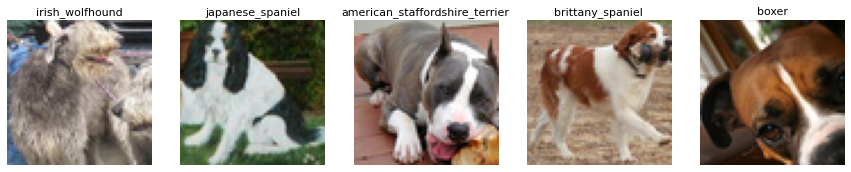

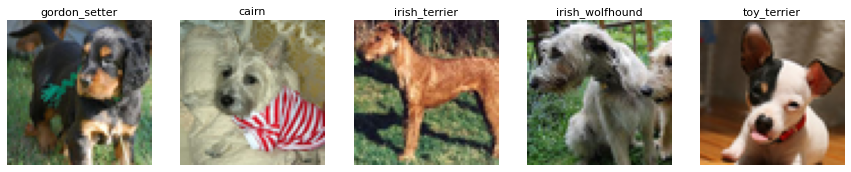

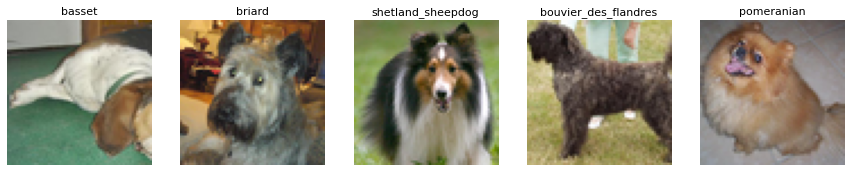

In [9]:
# DISPLAY CROPPED IMAGES

# list of 25 random numbers in range 0, idxIn
# this allows for displaying random images in the for loop using x[k*5+j]
x = np.random.randint(0, len(imgs), 25)

for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imgs[x[k*5+j], :, :, :].astype('uint8'))
        plt.axis('off')
        plt.title(names[x[k*5+j]].split('-')[1], fontsize=11)
        plt.imshow(img)
plt.show()

In [10]:
# normalize the pixel values
imgs = (imgs - 127.5) / 127.5

In [11]:
imgs = imgs.astype(np.float32)

### Create tf dataset

In [12]:
ds = tf.data.Dataset.from_tensor_slices(imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

2022-08-01 13:19:10.426024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 13:19:10.546526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 13:19:10.547392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 13:19:10.549964: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>


2022-08-01 13:19:14.983578: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1087488000 exceeds 10% of free system memory.


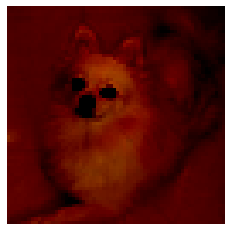

In [13]:
for x in ds:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


### Create the discriminator

It maps a 64x64 image to a binary classification score.

In [14]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

### Create the generator

It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

In [15]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

### Override train_step

In [16]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Create a callback that periodically saves generated images

In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

### Train the end-to-end model

In [18]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    ds, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

2022-08-01 13:19:17.108462: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1087488000 exceeds 10% of free system memory.
2022-08-01 13:19:18.130545: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1087488000 exceeds 10% of free system memory.


Epoch 1/100


2022-08-01 13:19:20.272643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-01 13:19:22.371751: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


692/692 [==============================] - 104s 137ms/step - d_loss: 0.2829 - g_loss: 43.8585
Epoch 2/100
692/692 [==============================] - 95s 137ms/step - d_loss: -0.2164 - g_loss: 77.7580
Epoch 3/100
692/692 [==============================] - 95s 137ms/step - d_loss: -0.1575 - g_loss: 63.7401
Epoch 4/100
692/692 [==============================] - 95s 137ms/step - d_loss: -2.5375 - g_loss: 582.3115
Epoch 5/100
692/692 [==============================] - 95s 137ms/step - d_loss: -2.9005 - g_loss: 916.8347
Epoch 6/100
692/692 [==============================] - 95s 137ms/step - d_loss: -6.3828 - g_loss: 1595.9944
Epoch 7/100
692/692 [==============================] - 95s 137ms/step - d_loss: -27.0833 - g_loss: 5134.8481
Epoch 8/100
692/692 [==============================] - 95s 137ms/step - d_loss: -18.7295 - g_loss: 5007.7466
Epoch 9/100
692/692 [==============================] - 95s 137ms/step - d_loss: -35.5201 - g_loss: 8024.5483
Epoch 10/100
692/692 [=======================

### Save submission

In [19]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')

for k in range(10000):
    generated_image = generator(tf.random.normal([1, NOISE_SIZE]), training=False)
    f = str(k) + '.png'
    img = ((generated_image[0,:,:,:] + 1.) / 2.).numpy()
    tf.keras.preprocessing.image